![logo](../img/LogoLine_horizon_C3S.png)

# How to access and use a satellite-derived GHG Level 2 data product using XCO2_EMMA as an example? 

## Introduction

This is a Jupyter Notebook (JN) illustrating how to access and use a satellite-derived Greenhouse Gas (GHG) atmospheric carbon dioxide (CO2) Level 2 data product as generated via the Copernicus Climate Change Service (C3S) and made available via the Copernicus Climate Data Store [CDS](https://cds.climate.copernicus.eu/).

Here we illustrate the use of a GHG Level 2 (L2) product using product XCO2_EMMA as an example. A CO2 L2 data product contains CO2 information for individual satellite ground pixels (also called footprints or soundings). XCO2 is the column-averaged dry-air mole fraction of atmospheric CO2 in parts per million (ppm). EMMA is the name of the multi-satellite XCO2 (and XCH4) merging algorithm developed to generate product XCO2_EMMA using as input individual Level 2 XCO2 products from different satellite sensors (here: SCIAMACHY/ENVISAT, GOSAT, GOSAT-2 and OCO-2; see, e.g., [Reuter et al., 2020](https://amt.copernicus.org/articles/13/789/2020/)). 

Within C3S also other L2 products are generated and made available via the CDS. These products are (i) XCO2 from individual satellite sensors, (ii) XCH4 products, where XCH4 is the column-averaged dry-air mole fraction of CH4 in parts per billion (ppb), and (iii) mid tropospheric CO2 and CH4 mixing ratio products. Detailed information on all these products is available via the CDS. In addition to L2 products, also Level 3 (L3) products are available. A L3 product is based on a corresponding L2 product. A L3 product is  obtained by spatio-temporally averaging a corresponding L2 product. How to access and use a L3 GHG product is shown in a separate Jupyter Notebook.

For this JN we use XCO2_EMMA version 4.4, which covers the period 2003 - 2021. 

This JN shows how to download a data product from the CDS, explains how to access the main variables and how to use them for a given applications. We focus on two use cases related to the spatial and temporal variation of atmospheric CO2 concentrations and their observational coverage. 

The first use case is related to the latitudial distribution of XCO2. We show how XCO2 averages and standard devations per latitude band can be computed and plotted. For this we use two days of observations, one in April and one in September. We explain that the observed latitudinal distributions are closely related to the seasonal cycle of CO2 due to uptake and release of CO2 by vegetation.

For the second use case we show how a map of the spatial distribution of the individual ground pixel XCO2 observations can be generated. We show that the spatial coverage of the daily observations is very sparse due to strict quality filtering of the individual XCO2 retrievals. Most applications therefore require appropriate spatio-temporal averaging (see, for example, the use of C3S GHG XCO2 and XCH4 data for assessments such as Copernicus European State of the Climate (ESOTC) as shown on the [GHG concentration climate indicators website]( https://climate.copernicus.eu/climate-indicators/greenhouse-gas-concentrations).

### What is needed to use this Jupyter Notebook?

In the following, Python 3 code is provided to read and plot the satellite data.

It is assumed that Python and Jupyter Notebook (JN) is installed on your computer, e.g., using the [Anaconda distribution](https://www.anaconda.com/products/distribution).

### Import libraries used in this tutorial

In [1]:
import cdsapi
import os
# from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import zipfile

## Data download from CDS

C3S GHG data products can be obtained from the CDS via the CDS user interface, or via the cdsapi as is demonstrated in this tutorial. 

The satellite-derived CO2 products, and documentation are available here: 
https://cds.climate.copernicus.eu/datasets/satellite-carbon-dioxide

Product XCO2_EMMA can be downloaded by manual selection in the "Download data" tab. Please select:
- Processing level: Level 2
- Variable: Column-average dry-air mole fraction of atmospheric Carbon Dioxide (XCO2) and related variables
- Sensor and algorithm: MERGED and EMMA

For the following we assume that data for 2 days have been downloaded:
- File 1: 15-April-2020
- File 2: 15-September-2020

It is also assumed that the following version and format of the data is selected:
- Version: 4.4 
- Format: Zip file 

The corresponding file names are:
- File 1: 20200415-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-v4.4.nc
- File 2: 20200915-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-v4.4.nc

The following code block will download these data files and extract them to the current directory ready for use in this tutorial. This assumes that you have installed the cdsapi and configured you .cdsapirc file with your key, as described in the "Climate Data Store Tutorial".

In [2]:
URL = 'https://cds-beta.climate.copernicus.eu/api'
KEY = '#################'

In [11]:
download_zip_file = "download.zip"
dataset = "satellite-carbon-dioxide"
request = {
    'processing_level': ['level_2'],
    'variable': 'xco2',
    'sensor_and_algorithm': 'merged_emma',
    'year': ['2020'],
    'month': ['04', '09'],
    'day': ['15'],
    'version': ['4_4'],
    "format": "zip",
}

client = cdsapi.Client(url=URL,key=KEY)
client.retrieve(dataset, request).download(download_zip_file)

with zipfile.ZipFile(download_zip_file) as zf:
    zf.extractall()


2024-11-12 12:56:07,819 WARNING [2024-11-12T11:56:07.792481] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-11-12 12:56:07,820 INFO Request ID is 77b2a057-0cc7-4c0f-9759-4ef2d4ae0675
2024-11-12 12:56:16,695 INFO status has been updated to running
2024-11-12 12:56:24,725 INFO status has been updated to successful


84f19408af95d4e3f2e0b0a8ad95ddb4.zip:   0%|          | 0.00/2.03M [00:00<?, ?B/s]

### Set some options that are used in this tutorial

Here some information on the selected product (which will be used later for the plots):

In [12]:
product_id = 'XCO2_EMMA' 
product_version = '4.4'  
product_str = product_id+' (v'+product_version+')'

Here some information on the selected days and corresponding file names:

In [13]:
# For file 1:
year_1_str = '2020'; month_1_str = '04'; month_name_1_str = 'Apr'; day_1_str = '15'
L2_file_1 = '20200415-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-v4.4.nc'
file_1_date = year_1_str+month_1_str+day_1_str
file_1_date2 = day_1_str+'-'+month_name_1_str+'-'+year_1_str
if os.path.exists(L2_file_1):
   print(f'File 1 exists: {L2_file_1}')
else:
   print('File 1 not found, please data downloaded and extracted correctly')

# For file 2:
year_2_str = '2020'; month_2_str = '09'; month_name_2_str = 'Sep'; day_2_str = '15'
L2_file_2 = '20200915-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-v4.4.nc'
file_2_date = year_2_str+month_2_str+day_2_str
file_2_date2 = day_2_str+'-'+month_name_2_str+'-'+year_2_str
if os.path.exists(L2_file_2):
   print(f'File 2 exists: {L2_file_2}')
else:
   print('File 2 not found, please data downloaded and extracted correctly')


File 1 not found, please data downloaded and extracted correctly
File 2 not found, please data downloaded and extracted correctly


## Open data files with xarray

We open the first file with xarray, and then set some of the variables to be coordinates (`latitude`, `longitude` and `time`).

The print out of the `xarray.Dataset` allows you to explore the contents of the file. For this tutorial we will be using the `xco2` variable.

In [14]:
ds_1 = xr.open_dataset(L2_file_1)

ds_1 = ds_1.assign_coords({
   "latitude": ds_1.latitude,
   "longitude": ds_1.longitude,
   "time": ds_1.time,
})

ds_1

FileNotFoundError: [Errno 2] No such file or directory: '/home/randbee/Documents/Bia/repos/review-version-of-c3sTM/ecv-notebooks/20200415-C3S-L2_GHG-GHG_PRODUCTS-MERGED-MERGED-EMMA-DAILY-v4.4.nc'

Then repeat for file 2:

In [6]:
ds_2 = xr.open_dataset(L2_file_2)

ds_2 = ds_2.assign_coords({
   "latitude": ds_2.latitude,
   "longitude": ds_2.longitude,
   "time": ds_2.time,
})

ds_2


<xarray.Dataset> Size: 1MB
Dimensions:                  (sounding_dim: 5455, layer_dim: 10, level_dim: 11)
Coordinates:
    longitude                (sounding_dim) float32 22kB ...
    latitude                 (sounding_dim) float32 22kB ...
    time                     (sounding_dim) datetime64[ns] 44kB ...
Dimensions without coordinates: sounding_dim, layer_dim, level_dim
Data variables: (12/15)
    solar_zenith_angle       (sounding_dim) float32 22kB ...
    sensor_zenith_angle      (sounding_dim) float32 22kB ...
    xco2_quality_flag        (sounding_dim) int8 5kB ...
    xco2                     (sounding_dim) float32 22kB ...
    xco2_uncertainty         (sounding_dim) float32 22kB ...
    co2_profile_apriori      (sounding_dim, layer_dim) float32 218kB ...
    ...                       ...
    median_processor_id      (sounding_dim) int16 11kB ...
    median_uncertainty       (sounding_dim) float32 22kB ...
    median_uncertainty_se    (sounding_dim) float32 22kB ...
    median_uncertainty_ex    (sounding_dim) float32 22kB ...
    xco2_accuracy            (sounding_dim) float32 22kB ...
    contributing_algorithms  (sounding_dim) int8 5kB ...
Attributes: (12/37)
    title:                     EMMA
    institution:               IUP
    source:                     
    history:                    
    references:                M. Reuter, H. Bösch, H. Bovensmann, A. Bril, M...
    tracking_id:               3c1d15b4-db12-4365-809f-390ca631576b
    ...                        ...
    time_coverage_resolution:  P1D
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   GHG-CCI Licence: 
\nAs condition of using this...
    platform:                  Envisat, GOSAT, GOSAT-2, OCO-2
    sensor:                    SCIAMACHY, TANSO-FTS, TANSO-FTS-2, OCO-2
    spatial_resolution:

## Application 1: The latitudinal distribution of XCO2

Here our intention is to plot the data as a function of latitude. For this we first need to define the latitude bands.

In [7]:
print('* Computing latitude band center coordinates')
lat_band_width = 10.0  # Width of latitude band in deg
d_lat = lat_band_width*0.5
lat_band_min = -90.0 + d_lat
lat_band_max = 90.0 - d_lat
lat_band_bins = np.arange(-90, 91, lat_band_width)
n_lat_bands = int((lat_band_max - lat_band_min) / lat_band_width)+1
lat_band_center = np.zeros(n_lat_bands)
for ii in range(n_lat_bands):
   lat_band_center[ii] = lat_band_min + ii*lat_band_width
print('* lat_band_center: ', lat_band_center)
print('* lat_band_bins: ', lat_band_bins)

* Computing latitude band center coordinates
* lat_band_center:  [-85. -75. -65. -55. -45. -35. -25. -15.  -5.   5.  15.  25.  35.  45.
  55.  65.  75.  85.]
* lat_band_bins:  [-90. -80. -70. -60. -50. -40. -30. -20. -10.   0.  10.  20.  30.  40.
  50.  60.  70.  80.  90.]


### Computing XCO2 vs latitude

Now we compute the mean and standard deviation for each latitude band of XCO2 from files 1 and 2. As  we need to repeat this process for the data in file 1 and file 2, we will write a function to reduce the repetitive code.

(Note: we identify "No data" via a negative standard deviation)

In [8]:
def zonal_mean_and_std(dataset, lat_band_bins, lat_band_centres, variable="xco2"):
    # Group the data by latitude bands
    grouped = dataset[variable].groupby_bins('latitude', lat_band_bins)

    # Compute the zonal mean and standard deviation,
    # assign the latitude centres as coordinates, and use this as the dimension
    zonal_mean = grouped.mean()
    zonal_mean = zonal_mean.assign_coords(latitude=("latitude_bins", lat_band_center))
    zonal_mean = zonal_mean.swap_dims({'latitude_bins': 'latitude'})

    zonal_std = grouped.std()
    zonal_std = zonal_std.assign_coords(latitude=("latitude_bins", lat_band_center))
    zonal_std = zonal_std.swap_dims({'latitude_bins': 'latitude'})

    # finally, we mask the data where the standard deviation is zero
    zonal_mean = zonal_mean.where(zonal_std > 0)
    zonal_std = zonal_std.where(zonal_std > 0)

    return zonal_mean, zonal_std

Now calculate the mean and standard deviation using our function. We also caculate the mean+standard deviation and mean-standard deviation which will be used in the plot created below.

The print out of the xarray object shows that we have xco2 data in a DataArray with a single dimension, `latitude`

In [9]:
# Calculate the mean and standard deviation of the Dataset for each latitude band
xco2_lb_mean_1, xco2_lb_std_1 = zonal_mean_and_std(ds_1, lat_band_bins, lat_band_center)
xco2_lb_low_1 = xco2_lb_mean_1 - xco2_lb_std_1
xco2_lb_high_1 = xco2_lb_mean_1 + xco2_lb_std_1

xco2_lb_mean_2, xco2_lb_std_2 = zonal_mean_and_std(ds_2, lat_band_bins, lat_band_center)
xco2_lb_low_2 = xco2_lb_mean_2 - xco2_lb_std_2
xco2_lb_high_2 = xco2_lb_mean_2 + xco2_lb_std_2

xco2_lb_mean_1

<xarray.DataArray 'xco2' (latitude: 18)> Size: 72B
array([      nan,       nan,       nan,       nan,       nan, 409.20816,
       409.57675, 410.1195 , 411.09332, 413.27045, 414.57516, 415.732  ,
       414.9866 , 415.58185, 415.8857 ,       nan,       nan,       nan],
      dtype=float32)
Coordinates:
    latitude_bins  (latitude) object 144B (-90.0, -80.0] ... (80.0, 90.0]
  * latitude       (latitude) float64 144B -85.0 -75.0 -65.0 ... 65.0 75.0 85.0
Attributes:
    standard_name:  dry_atmosphere_mole_fraction_of_carbon_dioxide
    long_name:      column-average dry-air mole fraction of atmospheric carbo...
    units:          1e-6
    comment:        Retrieved column-average dry-air mole fraction of atmosph...

### Generation of xy plot showing XCO2 vs latitude

We can now plot this data using `matplotlib.pyplot`

* Generating XCO2 vs latitude plot ...


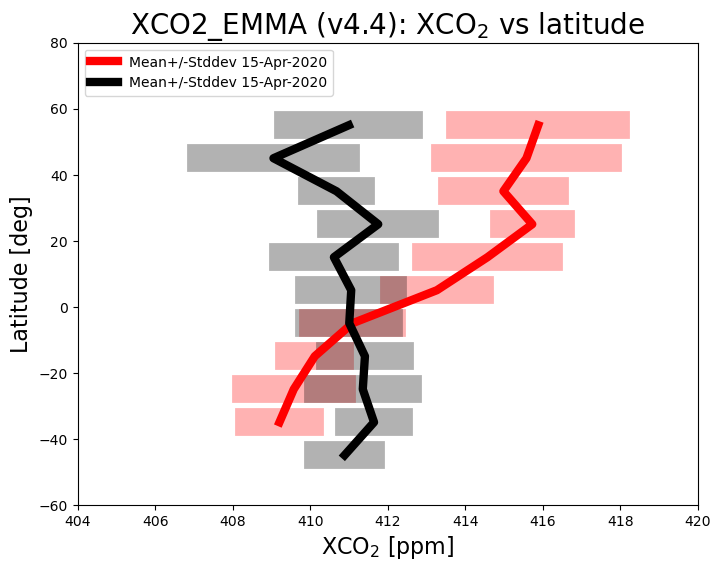

In [10]:
print('* Generating XCO2 vs latitude plot ...')
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[8, 6])
xmin = 404.0
xmax = 420.0
ymin = -60.0
ymax =  80.0

#  Plot the data and the ranges:
ax.plot(
    xco2_lb_mean_1, xco2_lb_mean_1.latitude,
    linewidth=6.0, color='red', zorder=39, label='Mean+/-Stddev '+file_1_date2
)
ax.plot(
    [xco2_lb_low_1, xco2_lb_high_1],
    [xco2_lb_mean_1.latitude, xco2_lb_mean_1.latitude],
    linewidth=20.0, color='red', zorder=38, alpha=0.3
)

ax.plot(
    xco2_lb_mean_2, xco2_lb_mean_2.latitude,
    linewidth=6.0, color='black', zorder=39, label='Mean+/-Stddev '+file_1_date2
)
ax.plot(
    [xco2_lb_low_2, xco2_lb_high_2],
    [xco2_lb_mean_2.latitude, xco2_lb_mean_2.latitude],
    linewidth=20.0, color='black', zorder=38, alpha=0.3
)

# Decorate the plot with some labels:
title = product_str
x_label = 'XCO$_2$ [ppm]'
y_label = 'Latitude [deg]'
plot_title = product_str+': XCO$_2$ vs latitude'
ax.set_title(plot_title, fontsize=20)
ax.set_xlabel(x_label, fontsize=16)
ax.set_ylabel(y_label, fontsize=16)
ax.set_xbound([xmin, xmax])
ax.set_ybound([ymin, ymax])
ax.legend(loc='upper left')
plt.show()

The figure above shows mean value of XCO2 as a function of latitude (thick lines) and the corresponding variation (computed as standard deviation of the individual XCO2 retrievals) within each latitude band (semi-transparent horizontal bars) for 15-April-2020 (red) and 15-September-2020 (black). As can be seen, during September XCO2 shows quite little variation with latitude, whereas in April XCO2 is significantly higher over the northern hemisphere (NH) compared to the southern hemisphere (SH). This is due to the seasonal cycle of CO2 primarily resulting from regular uptake and release of atmospheric CO2 by growing and decaying vegetation (photosythesis and respiration). Vegetation uptake reduces the CO2 concentration over the NH during the growing season (spring and summer) compared to the dormant season (winter). Over the SH there is less vegetation and therefore CO2 is relatively constant (apart from the general increase due to CO2 emissions by burning fossil fuels). 

## Application 2: Showing daily data on a map

Here we show how to generate a plot showing the spatial distribution of the data. As can be seen, we use only three variables: XCO2, latitude and longitude. We define a small region in terms of latitude and longitude corner coordinates and select only data in this region for the plot.

* Generating XCO2 map ...


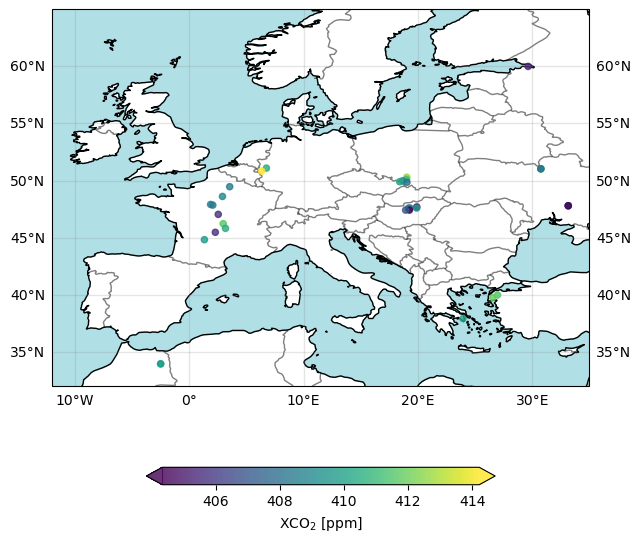

In [11]:
print('* Generating XCO2 map ...')
# # Relevant input data:
plot_title = product_str+' - '+file_2_date2
# Define spatial region of interest:
lonmin = -12.0
lonmax =  35.0
latmin =  32.0
latmax =  65.0

# Mask the data to the region of interest:
ds = ds_2
ds = ds.where(
    (latmin<ds.latitude) & (ds.latitude <latmax) &
    (lonmin<ds.longitude) & (ds.longitude <lonmax)
)
# Get the min and max values for the colorbar:
rmin=ds.xco2.min()
rmax=ds.xco2.max()

# Create a figure with a geographic projection:
projection = ccrs.PlateCarree()
figsize = (9,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection=projection)
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=projection)
ax.add_feature(cfeature.OCEAN, color='powderblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, alpha=0.5)
gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='gray', alpha=0.2)
gl.top_labels  = False

plt.scatter(
    x=ds.longitude, y=ds.latitude, c=ds.xco2, s=20, zorder=10, alpha=0.8, cmap='viridis',
    vmin=rmin, vmax=rmax
)
plt.colorbar(label='XCO$_2$ [ppm]', location='bottom', extend='both', shrink=0.5)
plt.show()

The figure above shows the locations of the individual ground pixel observations and their corresponding XCO2 value using all "good" retrievals over Europe and surrounding area for 15-Sept-2020. As can be seen, the spatial coverage of the daily data is very sparse. This is because only data of the highest quality are contained in the product file. Strict quality filtering is important to meet the demanding requirements on accuracy and precision for satellite XCO2 data observations.